In [ ]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-syc_4_jx
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-syc_4_jx
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-gyc8mqv7/residual-flows_348bf1a8898d45c1a24eaf5bc0a1db13
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-gyc8mqv7/residual-flows_348bf1a8898d45c1a24eaf5bc0a1db13
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=eded71269a99ede58f9f512e6fa07c429ee331e2263a50f9bf2dcb47bdc66524
  Stored in directory: /tmp/pip-ephem-wheel-cache-vq5v9x_s/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=c7ef3a

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# For saving and loading
import pickle
%matplotlib inline

In [ ]:
K = 10
beta = 1.0
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

# Normalizing Flow demo

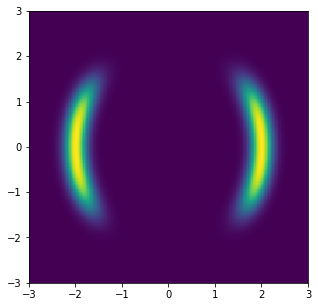

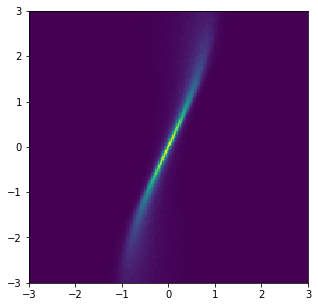

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(2), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z)
        #print(log_q)
        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=nf.distributions.DiagGaussian(2), flows=flows, p=target).to(device)

 40%|███▉      | 1981/5000 [00:07<00:11, 266.66it/s]

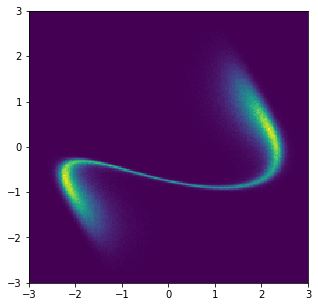

 80%|███████▉  | 3985/5000 [00:15<00:03, 260.74it/s]

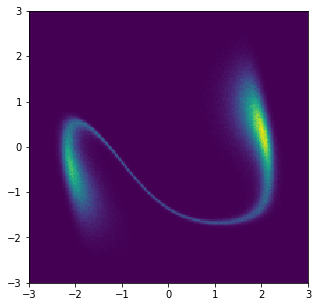

100%|██████████| 5000/5000 [00:19<00:00, 251.18it/s]


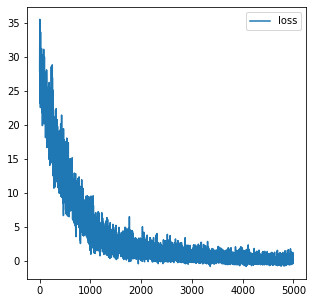

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

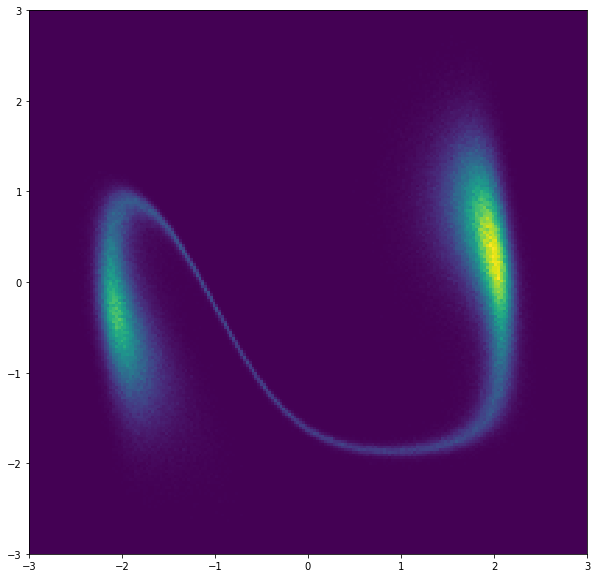

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Learning water molecule distribution

In [ ]:
# Install Openmm (takes approx 5 minutes to run)
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
--2022-05-29 13:50:53--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   297MB/s    in 0.3s    

2022-05-29 13:50:53 (297 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h

In [ ]:
from openmm import *
from openmm.app import *
from openmm.unit import *

# Import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Frequently used definitions
dtype = torch.FloatTensor
#enable_cuda = False
#device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'water_img1024_dim25_nse1_blob0.001_q0.2.pkl' #'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 5
beta = 100.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


In [ ]:
# Utility functions for putting gaussian blobs and Cryo-EM image plotting

def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_mat=torch.eye(3)):
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))

    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    normals = torch.zeros_like(x, device=device)

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = coords @ rot_mat.T

    for row in new_coords.double():
        #var = torch.distributions.multivariate_normal.MultivariateNormal(row[0:2],\
        # blob_sigma*torch.eye(2, device=device).double())
        #normals = normals + torch.exp(var.log_prob(pos))
        normals += torch.exp(-(torch.norm(pos - row[0:2], dim=2)**2)/(2*(blob_var)))/(2*torch.tensor(np.pi)*(blob_var))

    return normals/len(new_coords) + noise_matrix


def plot_cryoem_imgs(img_list, skip_by=1, Q=Q):
    for idx, img in enumerate(img_list):
        if idx % skip_by == 0:
            c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                            extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
            plt.colorbar(c)

            plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
            plt.show()

In [ ]:
class pot_energy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        reshaped_input = input.reshape(num_atoms, 3)
        ctx.save_for_backward(reshaped_input)

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return torch.tensor(state.getPotentialEnergy()._value).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        reshaped_input, = ctx.saved_tensors

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return -grad_output * torch.tensor(state.getForces(asNumpy=True)._value).reshape(-1, num_atoms*3).to(device)

In [ ]:
topology = Topology()
chain = topology.addChain()
residue = topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = topology.addAtom("O", element_O, residue)
atom1 = topology.addAtom("H", element_H, residue)
atom2 = topology.addAtom("H", element_H, residue)
topology.addBond(atom0, atom1)
topology.addBond(atom0, atom2)

#pdb = PDBFile(pdbfile)
forcefield = ForceField(forcefile)
system = forcefield.createSystem(topology, nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(T*kelvin, 1/picosecond, 1*femtoseconds)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.1],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))
#simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
#        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    print(state0.getPositions(asNumpy=True))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

Potential energy
0.3049052536721496 kJ/mol
Atomic positions
[[-0.00655403  0.01137912  0.00762747]
 [ 0.08193941 -0.0086883  -0.03713655]
 [ 0.00832808  0.00077646  0.10714486]] nm
Volume
8.0 nm**3
Forces
[[ 306.03094746  -90.79512341  162.09084279]
 [ -92.48321722   37.61447093 -199.69126945]
 [-213.54773024   53.18065247   37.60042666]] kJ/(nm mol)


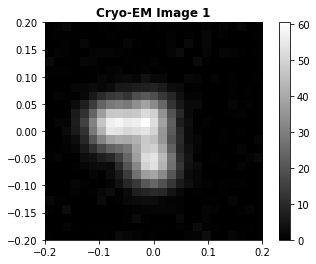

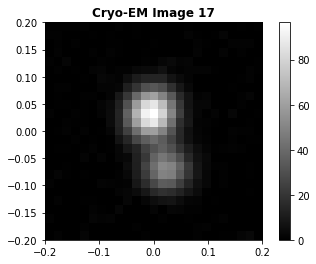

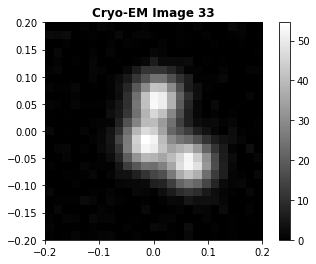

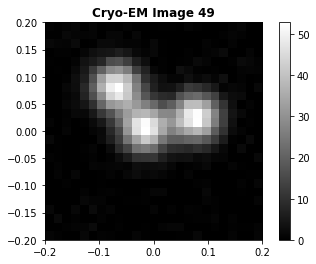

In [ ]:
with open(pklfile, 'rb') as inp:
    rot_mats = pickle.load(inp)[0:num_imgs]
    pot_energies = pickle.load(inp)[0:num_imgs]
    forces_list = pickle.load(inp)[0:num_imgs]
    pos_list = pickle.load(inp)
    img_list = pickle.load(inp)[0:num_imgs]

plot_cryoem_imgs(img_list, skip_by=16)

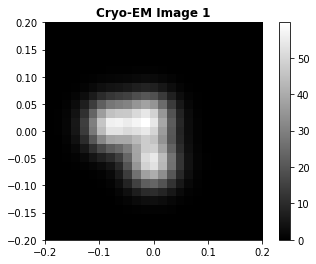

tensor(601.6717)
tensor([[-0.0103,  0.0218,  0.0047],
        [-0.0828,  0.0113, -0.0651],
        [-0.0038, -0.0601,  0.0637]])


In [ ]:
img = torch_createblobs(pos_list[0], rot_mat=rot_mats[0])

plot_cryoem_imgs([img], skip_by=1)
print(torch.norm(img - img_list[0])**2)
print(pos_list[0] @ rot_mats[0].T)

# Normalizing Flows

In [ ]:
# Initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

In [ ]:
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

q0 = nf.distributions.DiagGaussian(num_atoms*3)
target = img_list[0]

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(num_atoms*3), flows=flows):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, target=target, rot_mat=rot_mats[0], template=pos_list[0], beta=beta):
        z, log_q = self.q0(num_samples)

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            log_imerr -= torch.norm(target - torch_createblobs(molecule.reshape(3,3)/100, rot_mat = rot_mat))**2
            log_pot -= pot_energy.apply(molecule.reshape(-1, num_atoms*3)/100)

        return torch.mean(log_q) - (log_imerr/(2*noise_var) + beta*log_pot/kBxAvoxT)/num_samples 


model = nfmodel(q0=nf.distributions.DiagGaussian(num_atoms*3), flows=flows).to(device)

  0%|          | 3/2000 [00:00<03:46,  8.83it/s]

71259.66


 10%|█         | 203/2000 [00:18<02:44, 10.94it/s]

8329.861


 20%|██        | 402/2000 [00:36<02:22, 11.18it/s]

1080.3004


 30%|███       | 602/2000 [00:54<02:07, 10.93it/s]

713.64246


 40%|████      | 802/2000 [01:13<01:51, 10.77it/s]

566.40576


 50%|█████     | 1002/2000 [01:31<01:27, 11.34it/s]

490.56348


 60%|██████    | 1202/2000 [01:49<01:11, 11.22it/s]

434.91718


 70%|███████   | 1402/2000 [02:07<00:53, 11.11it/s]

425.03534


 80%|████████  | 1602/2000 [02:25<00:35, 11.07it/s]

385.91324


 90%|█████████ | 1802/2000 [02:43<00:17, 11.09it/s]

378.57904


100%|██████████| 2000/2000 [03:01<00:00, 10.99it/s]


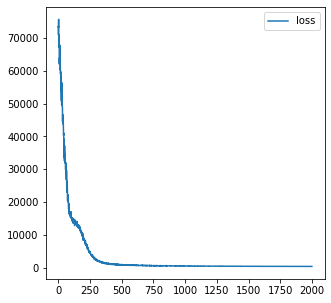

In [ ]:
# Train model
max_iter = 2000
num_samples = 40
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

tensor([[-0.0839,  0.0113,  0.0090],
        [-0.0117,  0.0215,  0.1074],
        [-0.0033, -0.0590, -0.1048]], grad_fn=<MmBackward0>)
tensor(24.9550)


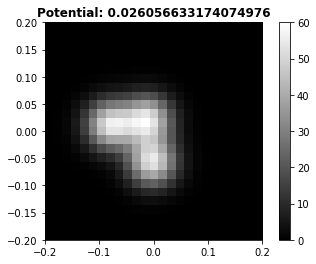

tensor([[-0.0849,  0.0127,  0.0090],
        [-0.0098,  0.0232,  0.1081],
        [-0.0008, -0.0595, -0.1037]], grad_fn=<MmBackward0>)
tensor(30.0860)


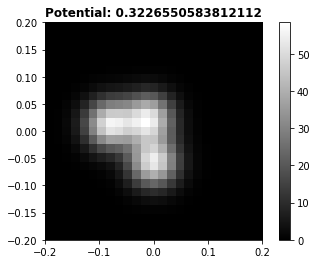

tensor([[-0.0840,  0.0113,  0.0068],
        [-0.0105,  0.0201,  0.1077],
        [-0.0028, -0.0594, -0.1011]], grad_fn=<MmBackward0>)
tensor(25.5273)


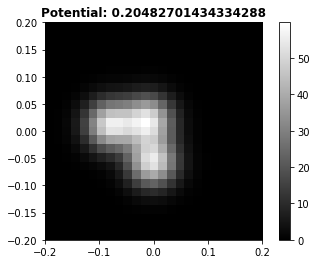

tensor([[-0.0814,  0.0112,  0.0116],
        [-0.0115,  0.0226,  0.1069],
        [-0.0021, -0.0616, -0.1056]], grad_fn=<MmBackward0>)
tensor(28.0178)


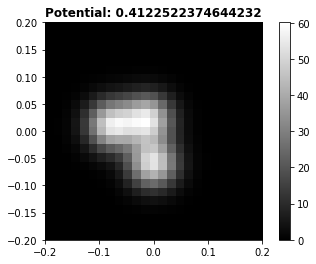

tensor([[-0.0841,  0.0116,  0.0094],
        [-0.0075,  0.0231,  0.1079],
        [-0.0040, -0.0581, -0.1024]], grad_fn=<MmBackward0>)
tensor(28.4033)


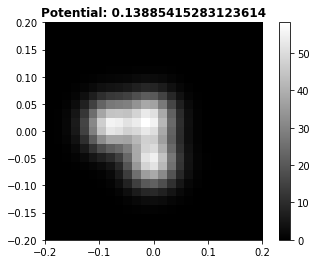

tensor([[-0.0828,  0.0118,  0.0109],
        [-0.0100,  0.0217,  0.1079],
        [-0.0047, -0.0597, -0.1072]], grad_fn=<MmBackward0>)
tensor(24.8376)


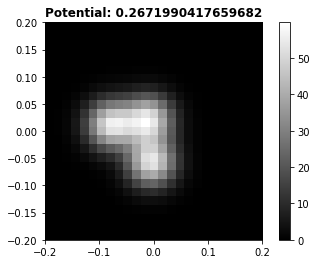

tensor([[-0.0846,  0.0102,  0.0089],
        [-0.0100,  0.0198,  0.1082],
        [-0.0049, -0.0570, -0.1047]], grad_fn=<MmBackward0>)
tensor(30.4154)


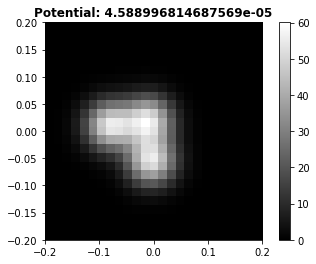

tensor([[-0.0812,  0.0107,  0.0087],
        [-0.0090,  0.0209,  0.1048],
        [-0.0027, -0.0616, -0.1016]], grad_fn=<MmBackward0>)
tensor(26.3652)


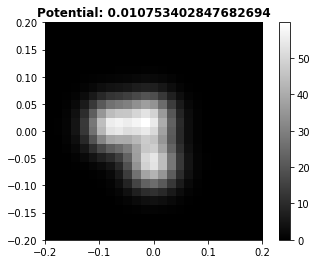

tensor([[-0.0827,  0.0120,  0.0103],
        [-0.0081,  0.0219,  0.1089],
        [-0.0019, -0.0606, -0.1041]], grad_fn=<MmBackward0>)
tensor(27.2893)


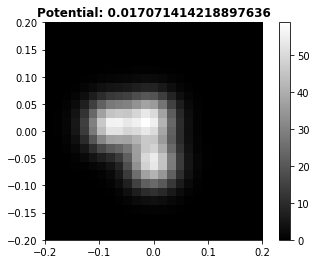

tensor([[-0.0817,  0.0115,  0.0079],
        [-0.0107,  0.0209,  0.1063],
        [-0.0044, -0.0585, -0.1001]], grad_fn=<MmBackward0>)
tensor(26.9126)


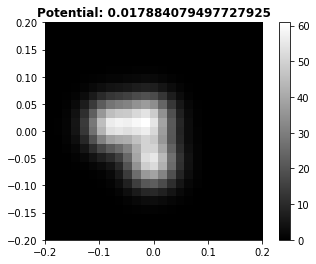

In [ ]:
molecules, _ = model.sample(num_samples=10)

for molecule in molecules:
    simulation.context.setPositions(molecule.reshape(3,3).data.numpy()/100)
    state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print((molecule.reshape(3,3)/100) @ rot_mats[0].T)

    img = torch_createblobs(molecule.reshape(3,3)/100, rot_mat=rot_mats[0]).data.numpy()
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[0]))
    plt.title(f'Potential: {state.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()

In [ ]:
print(pos_list[0] @ rot_mats[0].T)

tensor([[-0.0103,  0.0218,  0.0047],
        [-0.0828,  0.0113, -0.0651],
        [-0.0038, -0.0601,  0.0637]])


tensor([[ 0.0037,  0.0153,  0.0145],
        [ 0.0459, -0.0393, -0.0595],
        [-0.0950, -0.0072,  0.0144]])


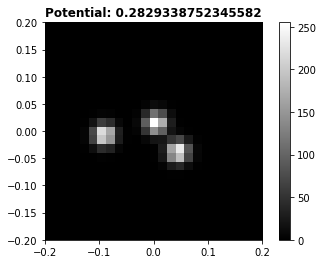

tensor([[ 0.0065,  0.0157,  0.0109],
        [-0.0373, -0.0340,  0.0874],
        [-0.0514,  0.0027, -0.0711]])


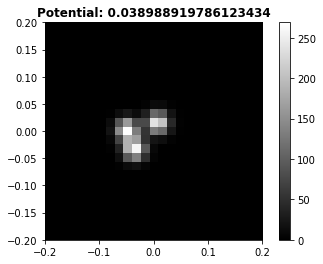

tensor([[-0.0050,  0.0158,  0.0073],
        [ 0.0016, -0.0813,  0.0351],
        [ 0.0776,  0.0577,  0.0481]])


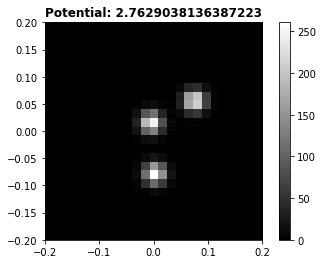

tensor([[-0.0032,  0.0173,  0.0077],
        [-0.0008,  0.0070,  0.1083],
        [ 0.0560, -0.0530, -0.0346]])


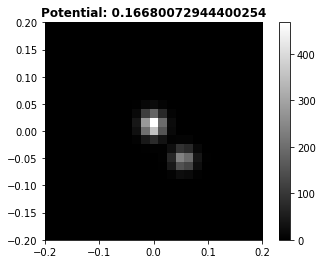

tensor([[ 0.0042,  0.0114,  0.0152],
        [-0.0009, -0.0284, -0.0777],
        [-0.0671,  0.0829,  0.0216]])


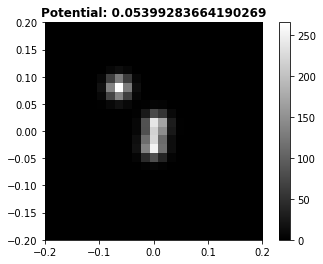

In [ ]:
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.1],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.minimizeEnergy()

for i in range(5):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    mol = torch.from_numpy(state0.getPositions(asNumpy=True)._value).type(dtype)
    print(mol)

    img = torch_createblobs(mol).data.numpy()
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    plt.title(f'Potential: {state0.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()

# Practice

In [ ]:
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

q0 = nf.distributions.DiagGaussian(num_atoms*3)

In [ ]:
class temp(nn.Module):
    def __init__(self, flows=flows):
        super().__init__()

        self.flows = nn.ModuleList(flows)

    def sample(self, z):
        final = self.z
        for flow in self.flows:
            final, _ = flow(final)
        return final


    def reverse_kld(self, z, log_q, target=torch.tensor(img_list[0]).type(dtype), rot_mat=torch.tensor(rot_mats[0]).type(dtype), beta=beta):
        molecule = z

        for flow in self.flows:
            #print(z)
            z, log_det = flow(z)
            log_q -= log_det

        log_p = torch.norm(target - torch_createblobs(molecule.reshape(3,3), rot_mat = rot_mat))**2
        return beta*log_p/(num_samples*2*noise_sigma**2) #+ translation/num_samples torch.mean(log_q) 


mod = temp(flows=flows).to(device)

  1%|          | 40/4000 [00:00<00:09, 397.65it/s]

28.656296


 12%|█▏        | 465/4000 [00:01<00:09, 359.59it/s]

28.656296


 21%|██        | 849/4000 [00:02<00:08, 365.31it/s]

28.656296


 31%|███       | 1242/4000 [00:03<00:07, 358.14it/s]

28.656296


 42%|████▏     | 1661/4000 [00:04<00:06, 368.58it/s]

28.656296


 52%|█████▏    | 2070/4000 [00:05<00:05, 360.59it/s]

28.656296


 62%|██████▏   | 2476/4000 [00:06<00:04, 367.34it/s]

28.656296


 71%|███████   | 2849/4000 [00:07<00:03, 361.60it/s]

28.656296


 82%|████████▏ | 3267/4000 [00:08<00:02, 361.12it/s]

28.656296


 91%|█████████ | 3642/4000 [00:10<00:01, 356.09it/s]

28.656296


100%|██████████| 4000/4000 [00:11<00:00, 361.75it/s]


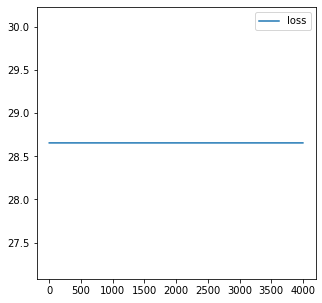

In [ ]:
# Train model
max_iter = 4000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = []
z, log_q = q0(1)

optimizer = torch.optim.Adam(mod.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = mod.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = mod.reverse_kld(z, log_q)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()